**Time Series/Sensor Data Prediction in Google Colab**

This lab demonstrates how to build and train neural networks for time series forecasting using sensor data. We'll use a synthetic dataset to predict future values based on historical patterns.

**Step 1: Setup Colab Environment**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

**Step 2: Generate Synthetic Sensor Data**

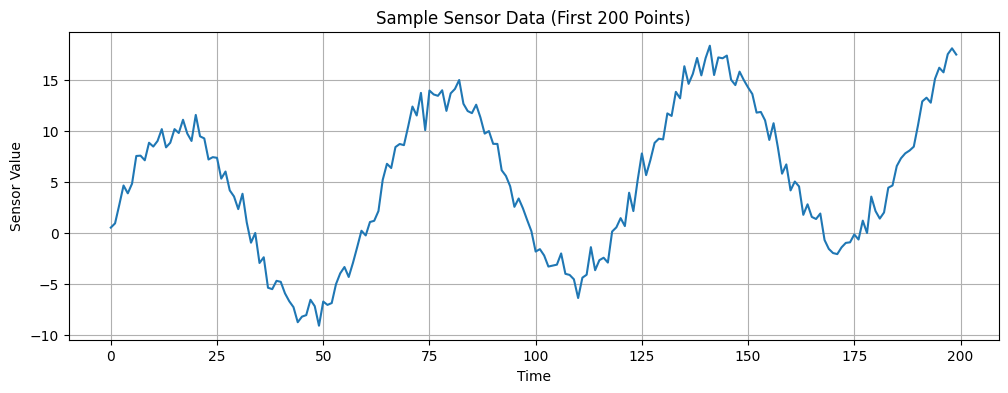

In [ ]:
# Create synthetic time series data with seasonality and noise
def generate_sensor_data(num_points=1000):
    time = np.arange(num_points)
    base = 10 * np.sin(time * 0.1)  # Daily seasonality
    trend = time * 0.05  # Upward trend
    noise = np.random.normal(0, 1, num_points)  # Random noise
    return base + trend + noise

sensor_data = generate_sensor_data()

# Plot first 200 points
plt.figure(figsize=(12, 4))
plt.plot(sensor_data[:200])
plt.title("Sample Sensor Data (First 200 Points)")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.grid(True)
plt.show()

**Step 3: Preprocess Time Series Data**

In [ ]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sensor_data.reshape(-1, 1)).flatten()

# Create time windows for supervised learning
def create_dataset(data, window_size=20, horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

window_size = 30
horizon = 5  # Predict next 5 steps
X, y = create_dataset(scaled_data, window_size, horizon)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Training shapes: X=(772, 30), y=(772, 5)
Test shapes: X=(193, 30), y=(193, 5)


**Step 4: Build Time Series Model**

In [ ]:
def build_timeseries_model(window_size, horizon):
    model = keras.Sequential([
        keras.layers.Input(shape=(window_size, 1)),
        keras.layers.Conv1D(64, 3, activation='relu', padding='causal'),
        keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(32)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(horizon)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

model = build_timeseries_model(window_size, horizon)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,165 (203.77 KB)

 Trainable params: 52,165 (203.77 KB)

 Non-trainable params: 0 (0.00 B)

**Step 5: Train the Model**

In [ ]:
# Add callbacks
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    factor=0.5,
    patience=3
)

# Reshape data for LSTM (samples, timesteps, features)
X_train_rs = X_train.reshape(-1, window_size, 1)
X_test_rs = X_test.reshape(-1, window_size, 1)

# Train model
history = model.fit(
    X_train_rs, y_train,
    validation_data=(X_test_rs, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.1695 - mae: 0.3538 - val_loss: 0.0543 - val_mae: 0.1988 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0192 - mae: 0.1154 - val_loss: 0.0157 - val_mae: 0.1027 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.0131 - mae: 0.0973 - val_loss: 0.0096 - val_mae: 0.0831 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0102 - mae: 0.0851 - val_loss: 0.0082 - val_mae: 0.0755 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0079 - mae: 0.0733 - val_loss: 0.0070 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0058 - mae: 0.0625 - val_loss: 0.0050 - val_mae: 0.0595 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0043 - mae: 0.0536 - val_loss: 0.0030 - val_mae: 0.0465 - learning_rate: 0.0010
Epoch 8/5

**Step 6: Evaluate and Visualize Predictions**

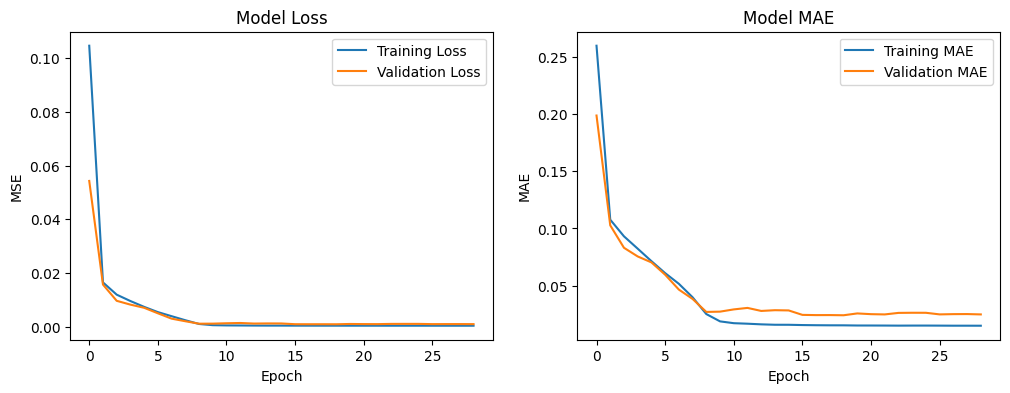

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


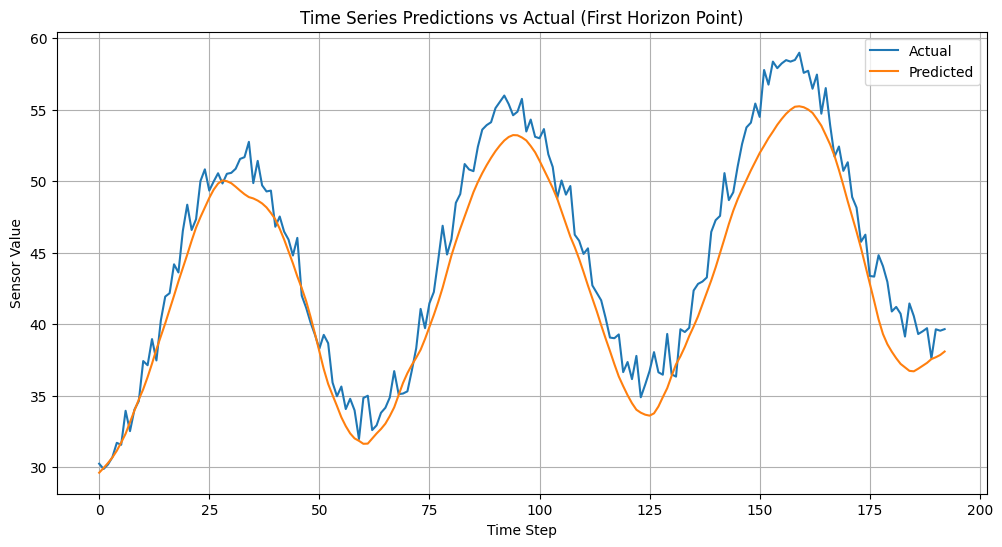

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Make predictions
test_predictions = model.predict(X_test_rs)

# Inverse transform predictions
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:, 0], label='Actual')
plt.plot(test_predictions[:, 0], label='Predicted')
plt.title("Time Series Predictions vs Actual (First Horizon Point)")
plt.xlabel("Time Step")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

**Step 7: Multi-Step Forecasting Function**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

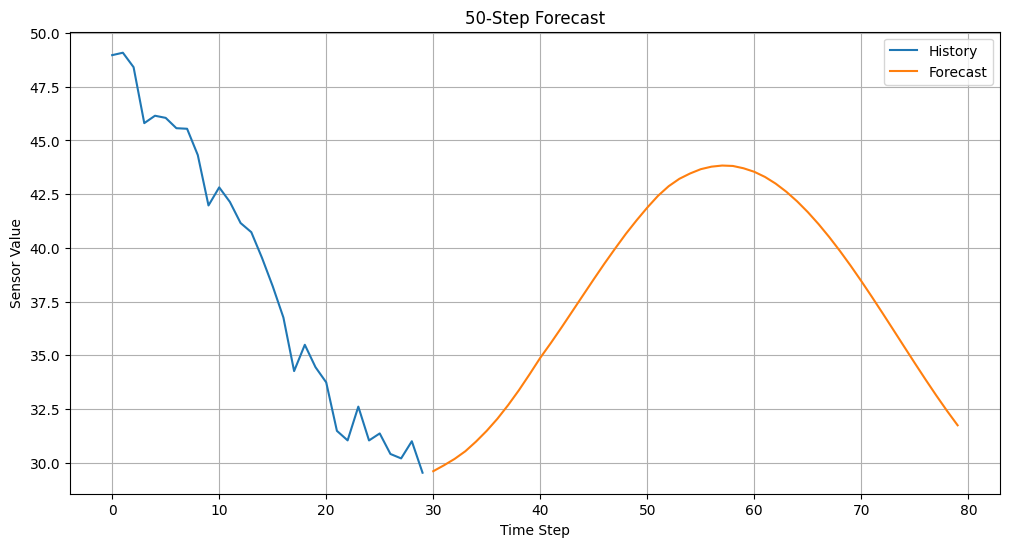

In [ ]:
def forecast_future(model, initial_sequence, steps_ahead, scaler):
    """Generate multi-step forecasts"""
    forecasts = []
    current_sequence = initial_sequence.copy()

    for _ in range(steps_ahead):
        # Reshape and predict
        pred = model.predict(current_sequence.reshape(1, window_size, 1))

        # Store prediction
        forecasts.append(pred[0, 0])

        # Update sequence (remove first, add prediction)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred[0, 0]

    return np.array(forecasts)

# Test forecasting
initial_seq = X_test[0]  # Get first test sequence
forecast_steps = 50
predictions = forecast_future(model, initial_seq, forecast_steps, scaler)

# Inverse transform and plot
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
initial_seq_actual = scaler.inverse_transform(initial_seq.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(initial_seq_actual, label='History')
plt.plot(range(len(initial_seq_actual), len(initial_seq_actual)+forecast_steps),
         predictions, label='Forecast')
plt.title(f"{forecast_steps}-Step Forecast")
plt.xlabel("Time Step")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()